## Importing Libraries.

In [1]:
# Importing all the libraries for the implementation.
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import seaborn as sns
sns.set()
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, RocCurveDisplay, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#### Loading auxiliary functions.

In [2]:
# Function for calculating the Thresholds for outliers. Calculating the inside 50%.
def outlier_thresholds(df, col_name):
  data_qtles = df.describe()
  q1 = data_qtles[col_name]['25%']
  q3 = data_qtles[col_name]['75%']
  IQR = q3-q1
  up_limit = q3 + 1.5*IQR
  low_limit = q1 - 1.5*IQR

  return low_limit, up_limit

# Function to obtain the number of registers that a feature consider as outlier.
def outliers_encounters(df, col_name):
  low, up = outlier_thresholds(df, col_name)
  num_outliers = len(df[((df[col_name] < low) | (df[col_name] > up))])

  print(f'Number of outliers for {col_name}:', num_outliers)

# Function to obtain a table based on missing values on any feature.
def missing_values_table(dataframe, na_name = False):
  # Array of columns that have missing rows.
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  # Number of missing values per feature.
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  # Ratio of missing values and total values.
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  # Making the table and showing it.
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
  print(missing_df, end="\n")

  if na_name:
    return na_columns

# Function to obtain if have impact on missing target based on missing table.
def missing_target(df, target, na_col):
  df_temp = df.copy()
  for col in na_cols:
    df_temp[col + '_NA_FLAG'] = np.where(df_temp[col].isnull(),1,0)
  na_flags = df_temp.loc[:, df_temp.columns.str.contains("_NA_")].columns
  print(na_flags)
  for col in na_flags:
    print(df_temp.groupby(col)[target].sum().head())
    print(pd.DataFrame({"TARGET_MEAN": df_temp.groupby(col)[target].mean(),
                          "Count": df_temp.groupby(col)[target].count()}), end="\n\n\n")

# Function to plot the correlation matrix.
def plot_correlation_matrix(matrix):
  plt.figure(figsize=(12,10))
  sns.heatmap(matrix, annot=True)
  plt.title("Correlation matrix heatmap")

# Function to make a classificator if the register is female or not.
def isFemale(row):
  if row["Sex"] == "female":
    return 1
  return 0

# Function to obtain MSE, based on the model and dataset.
def obtain_MSE(model, X, y):
  model.fit(X, y.values.ravel())

  some_data = X.iloc[:5]
  some_labels = y.iloc[:5]
  print("Predictions:", model.predict(some_data))
  print("Labels:", list(some_labels))

  survived_predictions = model.predict(X)
  mse = mean_squared_error(y, survived_predictions)
  print("MSE:", mse)
  print("RMSE:", np.sqrt(mse))

# Function to print the scores of a model.
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# Function to evaluate the test dataset based on the best model (with parameters),
# and show the classification report and the confusion matrix.
def evaluate_best_models(model, X, y, type):
  final_predictions = model.predict(X)
  final_dataset["Survived"] = final_predictions

  # Switch to save the best parameters for each model.
  match type:
    case 1:
      final_dataset.to_csv("DecisionTreePredictions.csv", header = True, index = False)
    case 2:
      final_dataset.to_csv("RandomForestPredictions.csv", header = True, index = False)
    case 3:
      final_dataset.to_csv("kNNPredictions.csv", header = True, index = False)
    case 4:
      final_dataset.to_csv("SVCPredictions.csv", header = True, index = False)
    case 5:
      final_dataset.to_csv("LogisticRegressionPredictions.csv", header = True, index = False)

  final_mse = mean_squared_error(y, final_predictions)

  print("Final MSE: ", final_mse)
  print("Final RMSE: ", np.sqrt(final_mse))
  print(classification_report(final_predictions, y))
  print(confusion_matrix(final_predictions, y), "\n")

## Load Dataset Based on Datasets from GitHub repository.

In [3]:
# Loading the all the datasets (train, test and true labels of test).
train_titanic_df = pd.read_csv("https://raw.githubusercontent.com/LeoDelgado23/TC3006IADS/main/train.csv", sep = ",")
test_titanic_df = pd.read_csv("https://raw.githubusercontent.com/LeoDelgado23/TC3006IADS/main/test.csv", sep = ",")
test_true_labels = pd.read_csv("https://raw.githubusercontent.com/LeoDelgado23/TC3006IADS/main/gender_submission.csv", sep = ",")
final_dataset = test_true_labels

# Verify loading into env showing its shapes.
train_titanic_df.shape, test_titanic_df.shape, test_true_labels.shape

((891, 12), (418, 11), (418, 2))

## 1) Exploration and Data Pre-processing.

#### a) Distributions.
<ul>
 <li> Verify if the data is balanced in the classes in which it should be separate the data.
 </li>
 <li> Analyze the distribution of categorical data and its relationship with the class "survived." Begin to identify characteristics relevant to an accurate classification.
 </li>
 <li> Understand the distribution of numerical data and determine if it is necessary to apply normalization or standardization processes.
 </li>
</ul>

In [4]:
# Reorganizing dataset only for visual purposes.
train_titanic_df = train_titanic_df[["PassengerId", "Name", "Sex", "Age", "Pclass", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked", "Survived"]]

In [5]:
# Showing information about the dataset.
train_titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Name         891 non-null    object 
 2   Sex          891 non-null    object 
 3   Age          714 non-null    float64
 4   Pclass       891 non-null    int64  
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Survived     891 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Show how distributed "Sex" feature is within the dataset.
train_titanic_df["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [7]:
# Show how distributed "Ticket" feature is within the dataset.
train_titanic_df["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [8]:
# Show how distributed "Cabin" feature is within the dataset.
train_titanic_df["Cabin"].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [9]:
# Show how distributed "Embarked" feature is within the dataset.
train_titanic_df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [10]:
# Showing statistics about the dataset.
train_titanic_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>],
       [<Axes: title={'center': 'Survived'}>, <Axes: >, <Axes: >]],
      dtype=object)

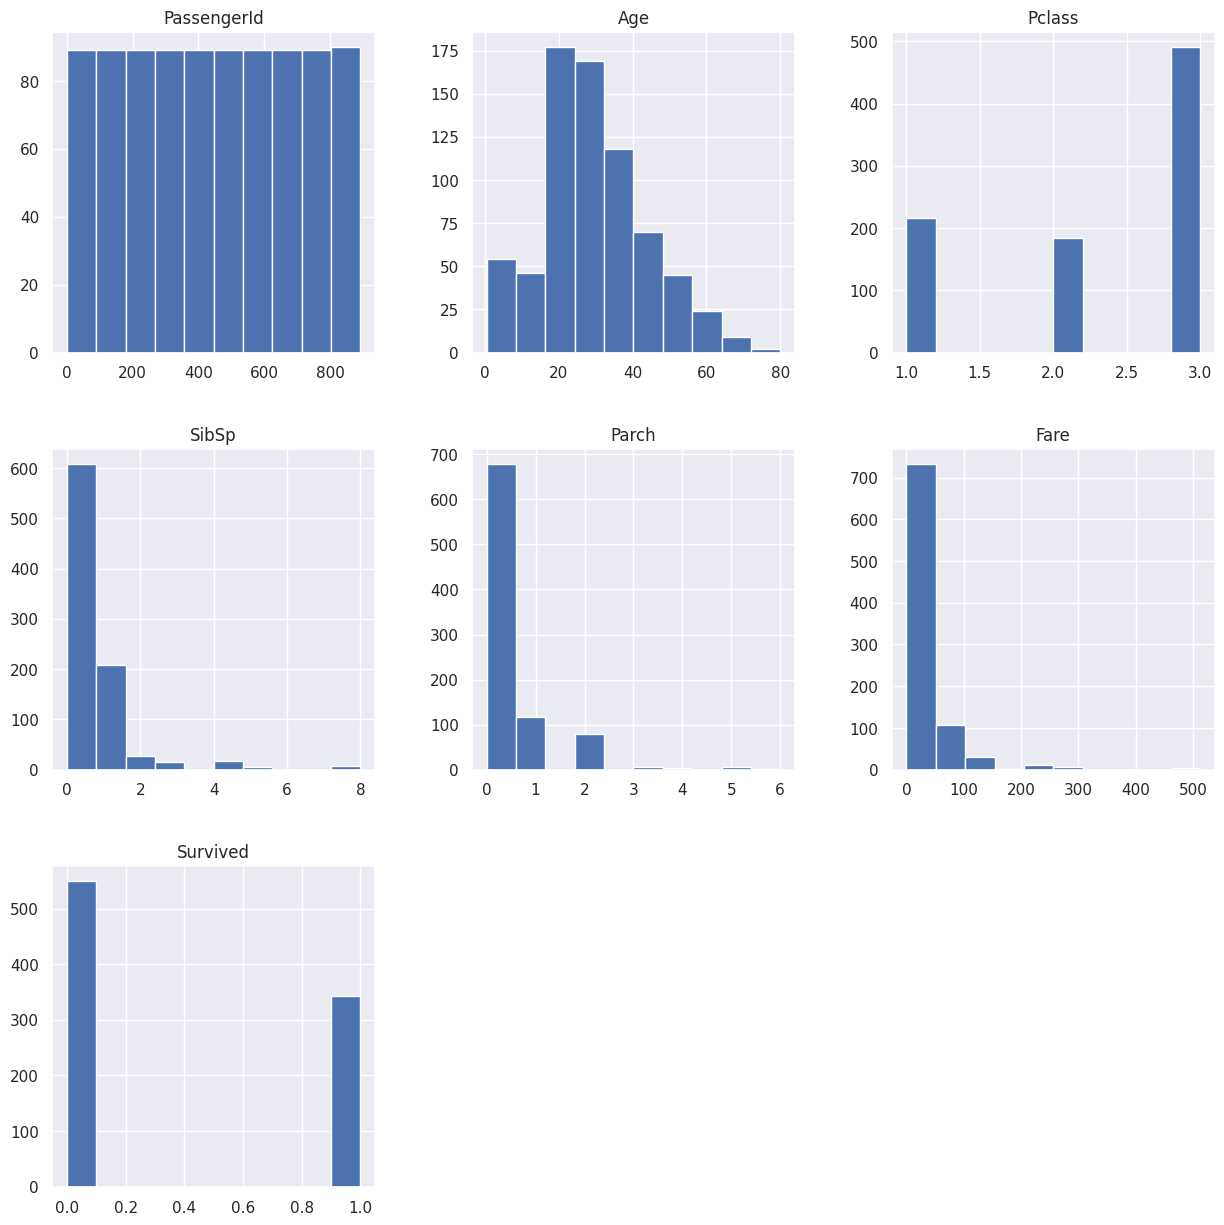

In [11]:
# Showing the distribution throughout the dataset.
train_titanic_df.hist(figsize = (15, 15), bins = 10)

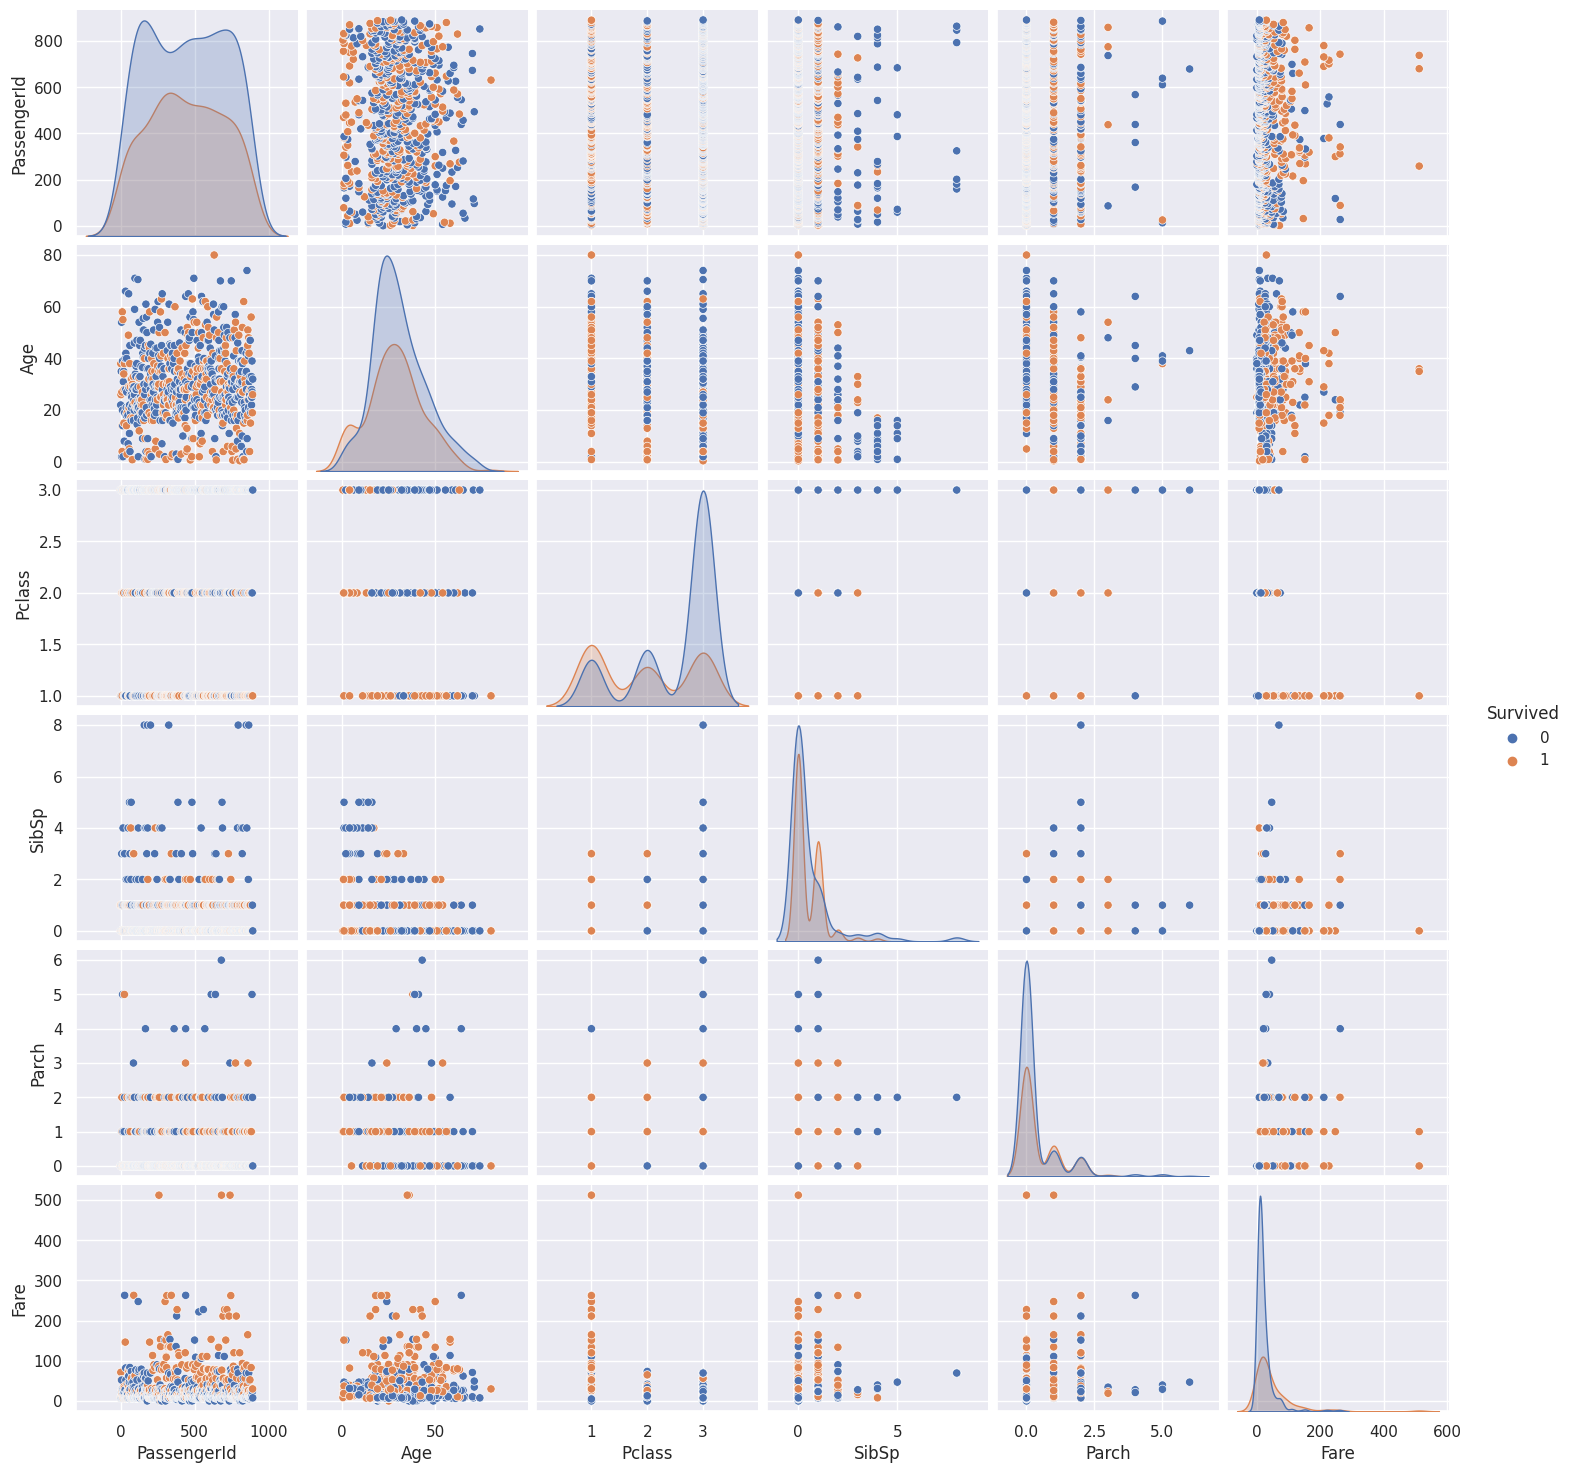

In [12]:
sns.pairplot(train_titanic_df, hue = 'Survived')

<Axes: xlabel='Survived', ylabel='Fare'>

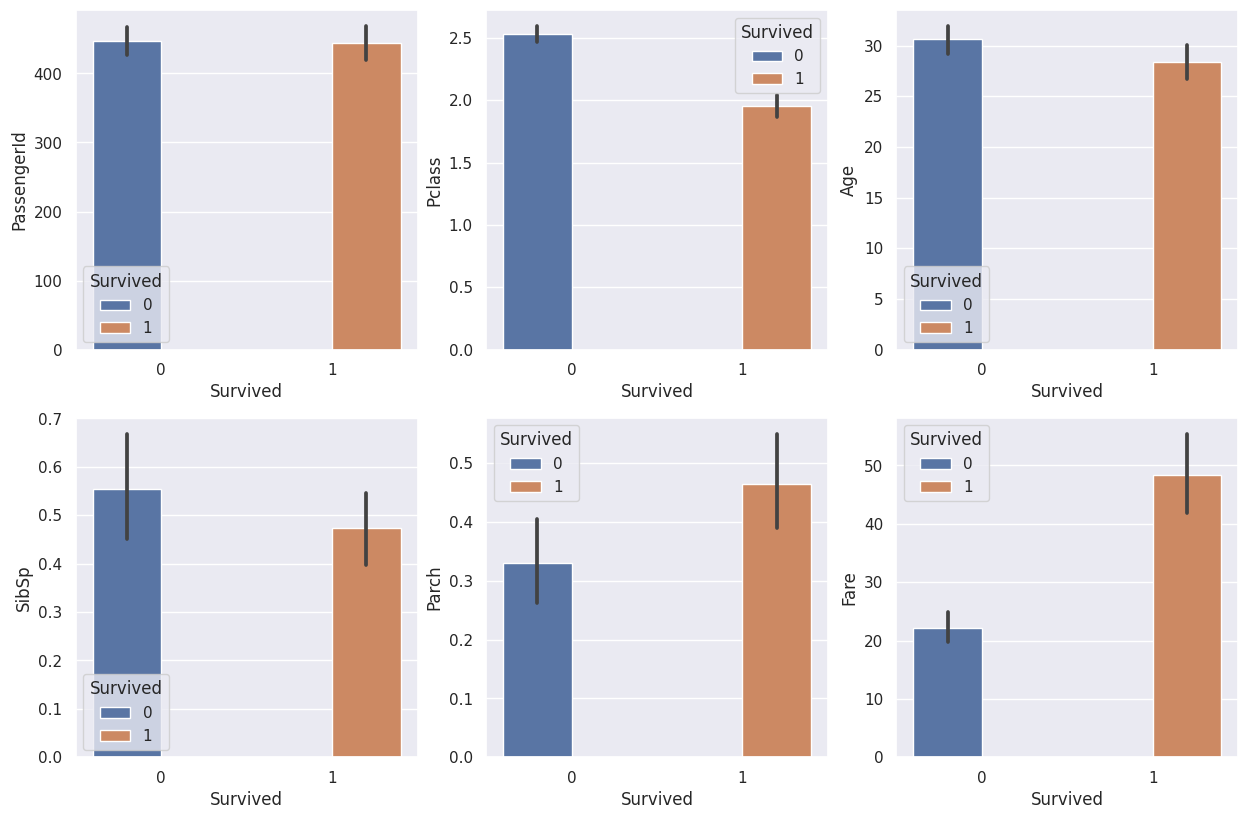

In [13]:
# Showing how each feature is distributed is our target class.
plt.figure(figsize=(15, 15))
plt.subplot(3,3,1)
sns.barplot(x = 'Survived', y = 'PassengerId', data = train_titanic_df, hue = "Survived")
plt.subplot(3,3,2)
sns.barplot(x = 'Survived', y = 'Pclass', data = train_titanic_df, hue = "Survived")
plt.subplot(3,3,3)
sns.barplot(x = 'Survived', y = 'Age', data = train_titanic_df, hue = "Survived")
plt.subplot(3,3,4)
sns.barplot(x = 'Survived', y = 'SibSp', data = train_titanic_df, hue = "Survived")
plt.subplot(3,3,5)
sns.barplot(x = 'Survived', y = 'Parch', data = train_titanic_df, hue = "Survived")
plt.subplot(3,3,6)
sns.barplot(x = 'Survived', y = 'Fare', data = train_titanic_df, hue = "Survived")

In [14]:
# Verify if the data is balanced in the target classes.
no_survived, survived = train_titanic_df['Survived'].value_counts()
print('% people DID NOT survived: {}%'.format(no_survived / (no_survived + survived) * 100))
print('% people DID survived: {}% \n'.format(survived / (no_survived + survived) * 100))

# Verify each gender percent of survivals.
women_survived = train_titanic_df.loc[train_titanic_df.Sex == "female"]['Survived']
rate_women = sum(women_survived)/len(women_survived)
print("% of women who survived:", rate_women)

men_survived = train_titanic_df.loc[train_titanic_df.Sex == "male"]['Survived']
rate_men = sum(men_survived)/len(men_survived)
print("% of men who survived:", rate_men)

% people DID NOT survived: 61.61616161616161%
% people DID survived: 38.38383838383838% 

% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924


#### b) Missing values.
<ul>
 <li> Identify and visualize missing data.
 </li>
 <li> Decide which characteristics require imputations and which do not. Justify the decision and remove unselected columns.
 </li>
 <li> Apply imputation techniques for missing data. Select the best technique and justify the choice.
 </li>
</ul>

In [15]:
# Identify if any feature has missing values.
train_titanic_df.isnull().sum()

PassengerId      0
Name             0
Sex              0
Age            177
Pclass           0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
dtype: int64

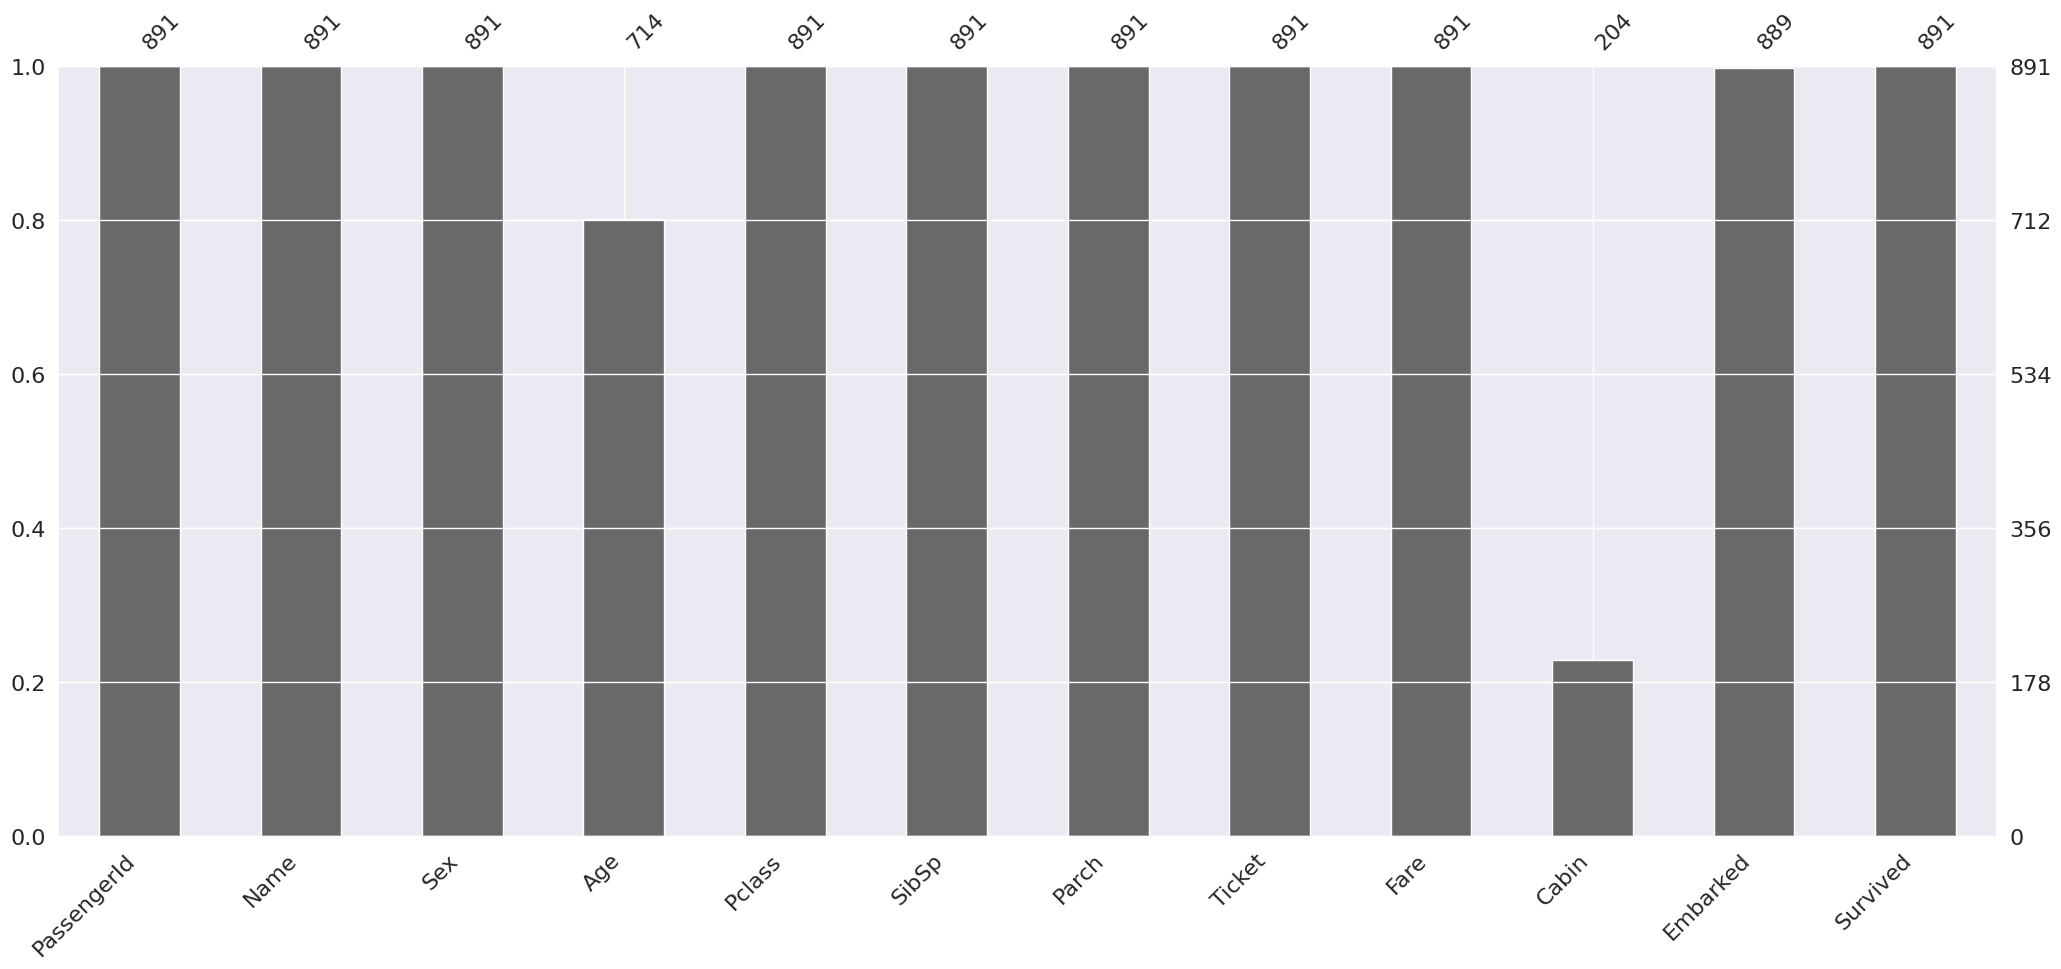

In [16]:
# Verify the missing values of the dataset.
missing_values = msno.bar(train_titanic_df)

<Axes: >

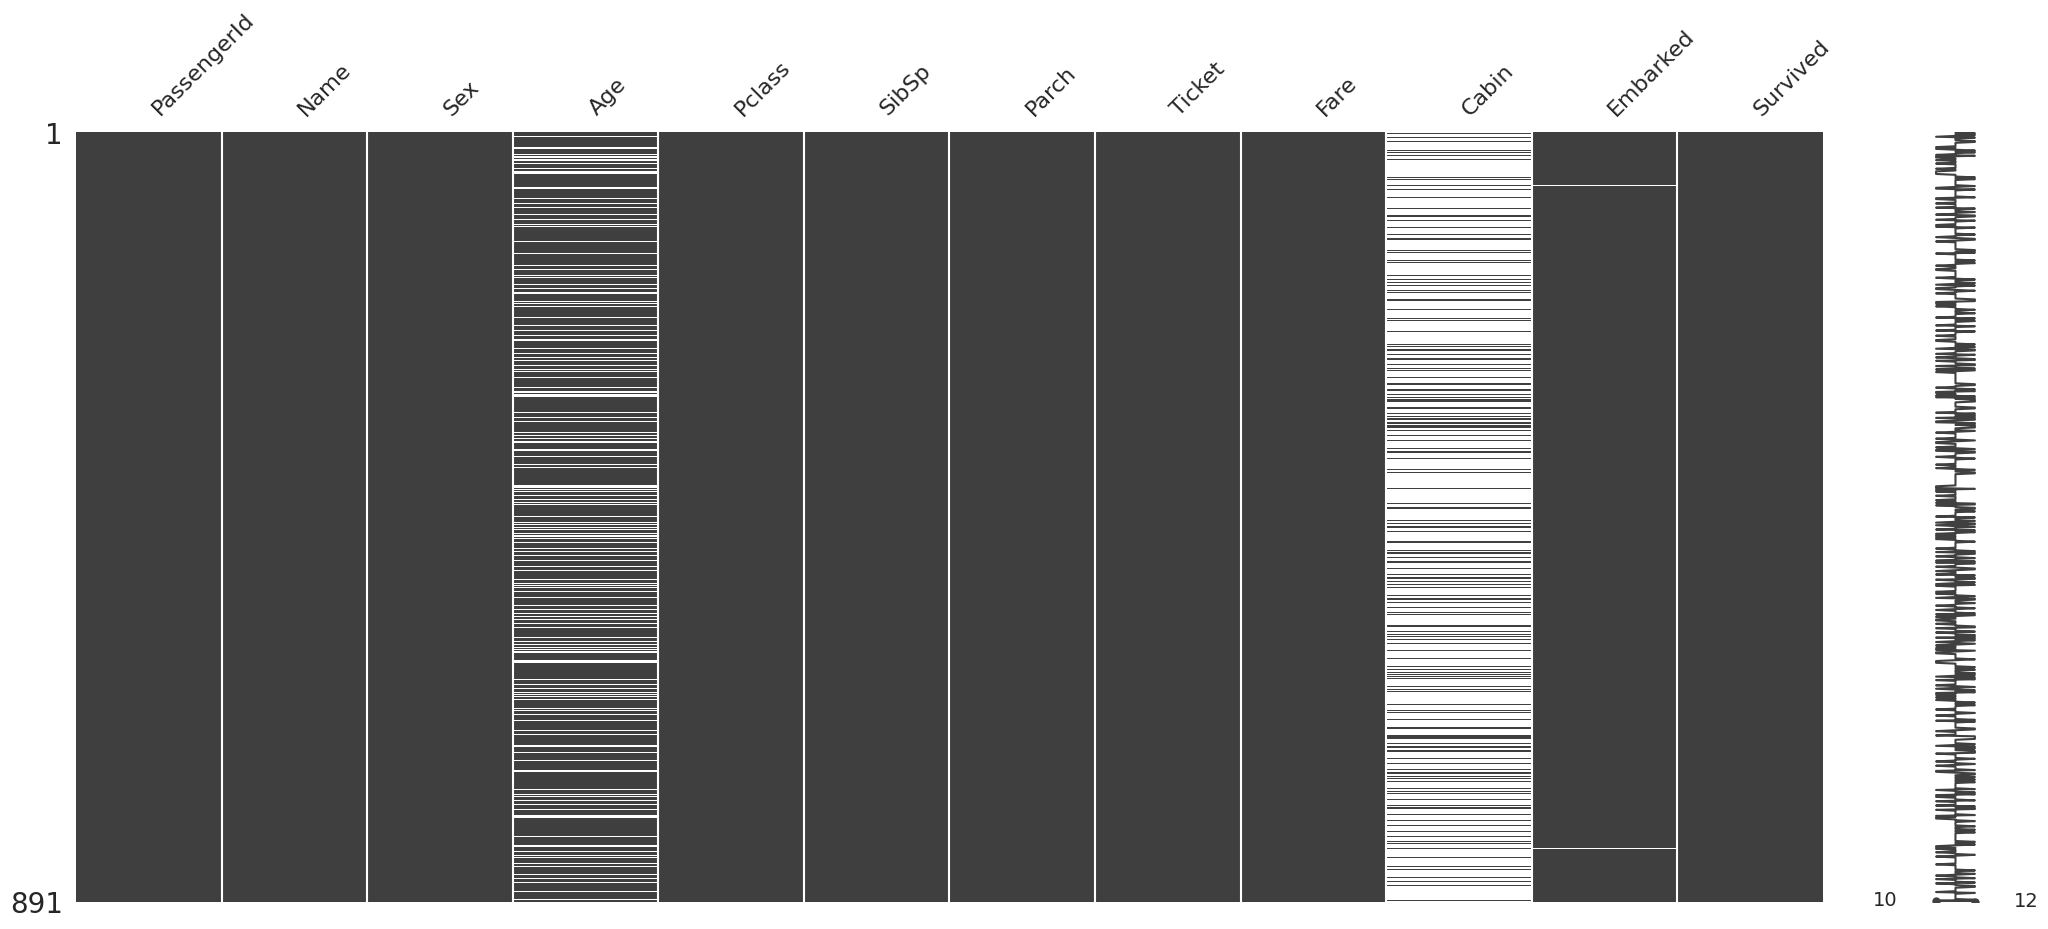

In [17]:
# Verify the missing values of the dataset per index or register.
msno.matrix(train_titanic_df)

<Axes: >

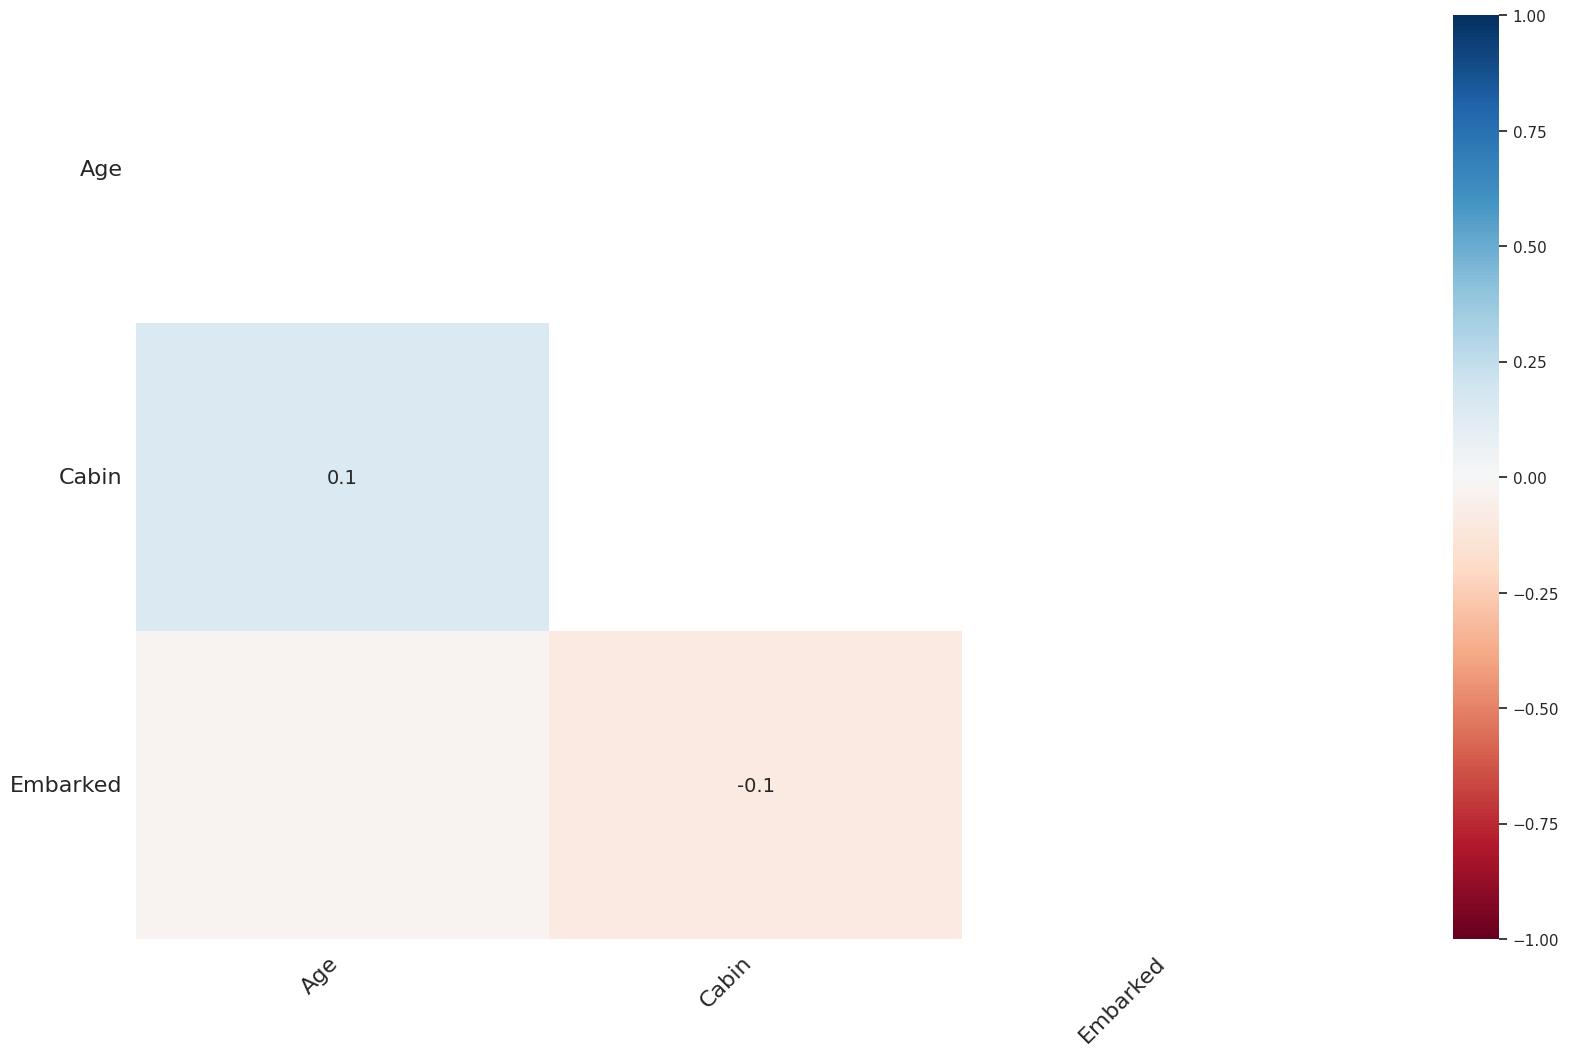

In [18]:
# Showing the correlation between the features that have missing values.
msno.heatmap(train_titanic_df)

In [19]:
# Obtain the thresholds that will say if a value is an outlier.
outlier_train_titanic_df = train_titanic_df[["Pclass","Age","SibSp","Parch","Fare"]]

for i in outlier_train_titanic_df.columns:
    print("Thresholds of {} : ({:.2f}, {:.2f})".format(i, *outlier_thresholds(outlier_train_titanic_df, i)))

Thresholds of Pclass : (0.50, 4.50)
Thresholds of Age : (-6.69, 64.81)
Thresholds of SibSp : (-1.50, 2.50)
Thresholds of Parch : (0.00, 0.00)
Thresholds of Fare : (-26.72, 65.63)


In [20]:
# Verify number of outliers for numerical features.
outliers_encounters(train_titanic_df, "Pclass")
outliers_encounters(train_titanic_df, "Age")
outliers_encounters(train_titanic_df, "SibSp")
outliers_encounters(train_titanic_df, "Parch")
outliers_encounters(train_titanic_df, "Fare")

Number of outliers for Pclass: 0
Number of outliers for Age: 11
Number of outliers for SibSp: 46
Number of outliers for Parch: 213
Number of outliers for Fare: 116


In [21]:
# Obtain a missing values per feature table.
na_cols = missing_values_table(train_titanic_df, True)

          n_miss  ratio
Cabin        687  77.10
Age          177  19.87
Embarked       2   0.22


In [22]:
missing_target(train_titanic_df, "Survived", na_cols)

Index(['Age_NA_FLAG', 'Cabin_NA_FLAG', 'Embarked_NA_FLAG'], dtype='object')
Age_NA_FLAG
0    290
1     52
Name: Survived, dtype: int64
             TARGET_MEAN  Count
Age_NA_FLAG                    
0               0.406162    714
1               0.293785    177


Cabin_NA_FLAG
0    136
1    206
Name: Survived, dtype: int64
               TARGET_MEAN  Count
Cabin_NA_FLAG                    
0                 0.666667    204
1                 0.299854    687


Embarked_NA_FLAG
0    340
1      2
Name: Survived, dtype: int64
                  TARGET_MEAN  Count
Embarked_NA_FLAG                    
0                    0.382452    889
1                    1.000000      2




In [23]:
# Fill the missing values of the features that we are going to keep.
train_titanic_df['Age'].fillna(train_titanic_df['Age'].median(), inplace=True)
train_titanic_df['Embarked'].fillna(train_titanic_df['Embarked'].mode()[0], inplace=True)

#### c) Correlation analysis.
<ul>
 <li> Perform a correlation analysis to decide which characteristics should kept and which ones to discard.
 </li>
</ul>

<ipython-input-24-ec157926f01b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_titanic_df.corr()


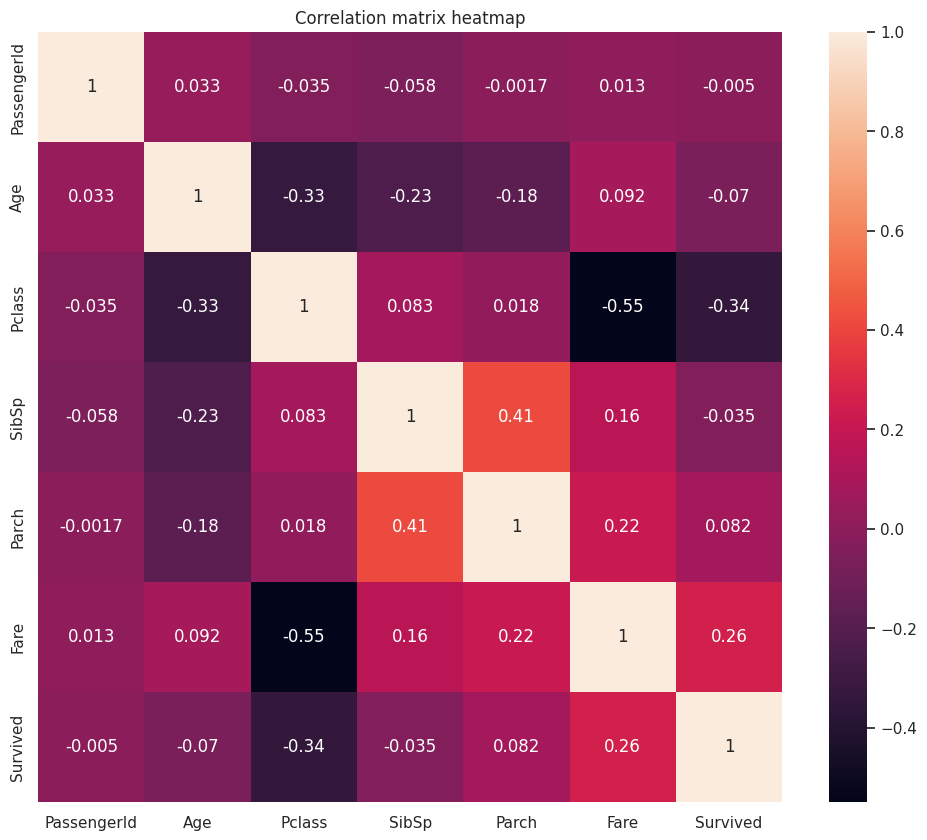

In [24]:
# Display a correlation matrix of the dataset.
corr_matrix = train_titanic_df.corr()
plot_correlation_matrix(corr_matrix)

In [25]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.069809
Pclass        -0.338481
Name: Survived, dtype: float64

#### d) Data Transformation.
<ul>
 <li> Convert categorical data to numerical data. Explore different methods and select the most suitable one. Justify the choice.
 </li>
</ul>

In [26]:
# Transforming sex categories into numerical here only to appear in plotting charts.
train_titanic_df["isFemale"] = train_titanic_df.apply(isFemale, axis = 1)

# Drop the features that we are not going to use and review the transformation of Sex.
train_titanic_df = train_titanic_df.drop(["PassengerId", "Name", "Sex", "Ticket", "Cabin"], axis = 1)
train_titanic_df["isFemale"].value_counts()

0    577
1    314
Name: isFemale, dtype: int64

<Axes: xlabel='Survived', ylabel='isFemale'>

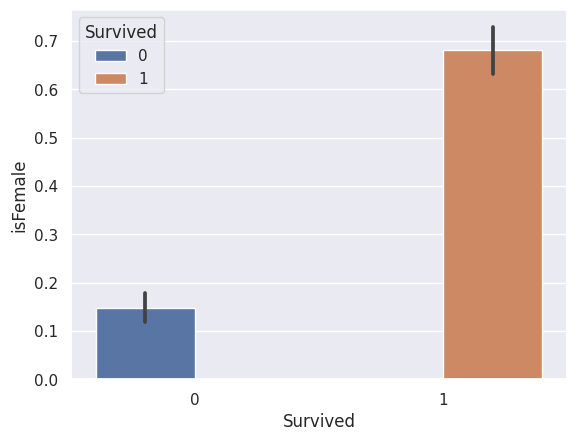

In [27]:
sns.barplot(x = 'Survived', y = 'isFemale', data = train_titanic_df, hue = "Survived")

In [28]:
# Make a standarization on the features.
scaler = StandardScaler()
features = ['Age', 'SibSp', 'Parch', 'Fare']
train_titanic_df[features] = scaler.fit_transform(train_titanic_df[features])

train_titanic_df = pd.get_dummies(train_titanic_df, columns=['Embarked'], prefix=['Embarked'])

train_titanic_df = train_titanic_df[["Age", "Pclass", "SibSp", "Parch", "Fare", "Embarked_C", "Embarked_Q", "Embarked_S", "isFemale", "Survived"]]
train_titanic_df.head(2)

,Age,Pclass,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,isFemale,Survived
0,-0.592481,3,0.432793,-0.473674,-0.502445,0,0,1,0,0
1,0.638789,1,0.432793,-0.473674,0.786845,1,0,0,1,1


In [29]:
# Showing information about the dataset.
train_titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         891 non-null    float64
 1   Pclass      891 non-null    int64  
 2   SibSp       891 non-null    float64
 3   Parch       891 non-null    float64
 4   Fare        891 non-null    float64
 5   Embarked_C  891 non-null    uint8  
 6   Embarked_Q  891 non-null    uint8  
 7   Embarked_S  891 non-null    uint8  
 8   isFemale    891 non-null    int64  
 9   Survived    891 non-null    int64  
dtypes: float64(4), int64(3), uint8(3)
memory usage: 51.5 KB


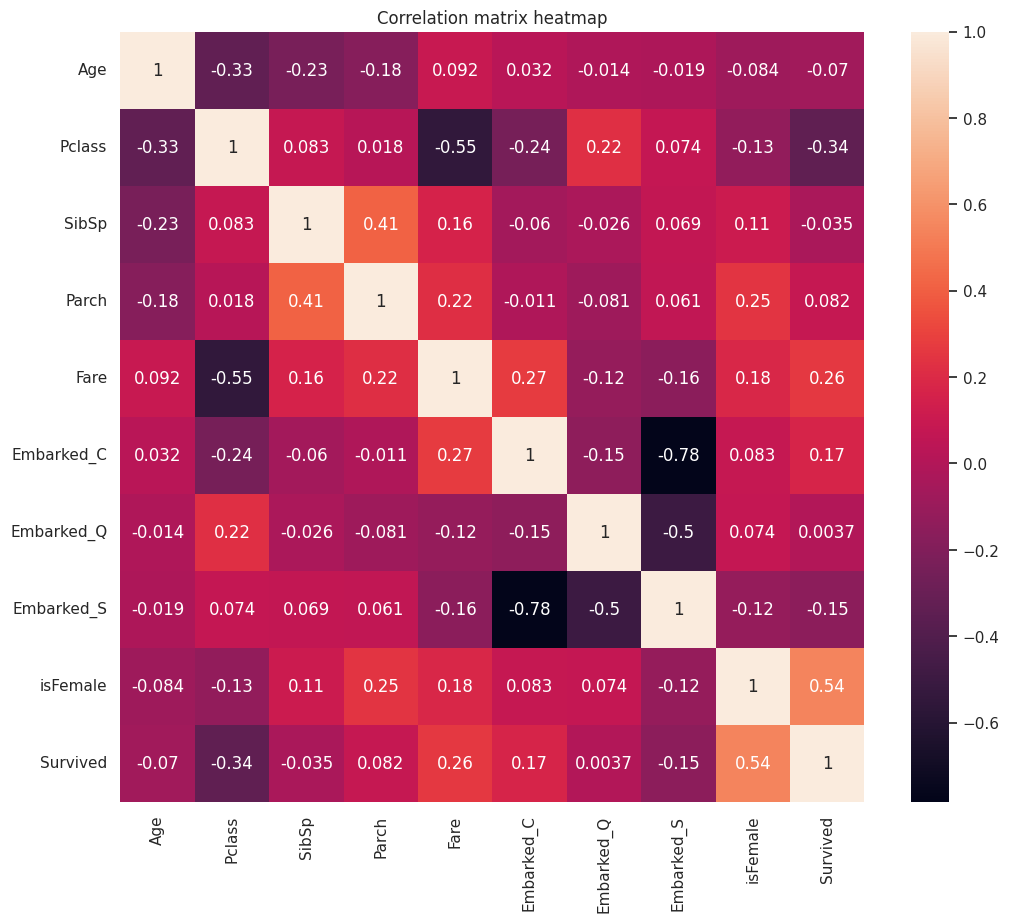

In [30]:
corr_matrix = train_titanic_df.corr()
plot_correlation_matrix(corr_matrix)

In [31]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived      1.000000
isFemale      0.543351
Fare          0.257307
Embarked_C    0.168240
Parch         0.081629
Embarked_Q    0.003650
SibSp        -0.035322
Age          -0.069809
Embarked_S   -0.149683
Pclass       -0.338481
Name: Survived, dtype: float64

## 2) Classification.


#### a) Classificators Selection.
<ul>
 <li> Choose three classification algorithms to be used in the project. Justify the selection of each algorithm.
 </li>
</ul>

In [32]:
# Split the dataset into features and target class.
X_train_titanic_df = train_titanic_df.drop(["Survived"], axis = 1)
y_train_titanic_df = train_titanic_df[["Survived"]]

In [33]:
# Load a Logistic Regression model and evaluate the model.
log_reg = LogisticRegression()
obtain_MSE(log_reg, X_train_titanic_df, y_train_titanic_df)

Predictions: [0 1 1 1 0]
Labels: ['Survived']
MSE: 0.19753086419753085
RMSE: 0.4444444444444444


In [34]:
# Load a Decision Tree model and evaluate the model.
tree_class = DecisionTreeClassifier()
obtain_MSE(tree_class, X_train_titanic_df, y_train_titanic_df)

Predictions: [0 1 1 1 0]
Labels: ['Survived']
MSE: 0.017957351290684626
RMSE: 0.13400504203456162


In [35]:
# Load a Random Forest model and evaluate the model.
rf_class = RandomForestClassifier()
obtain_MSE(rf_class, X_train_titanic_df, y_train_titanic_df)

Predictions: [0 1 1 1 0]
Labels: ['Survived']
MSE: 0.017957351290684626
RMSE: 0.13400504203456162


In [36]:
# Load a Support Vector Machine model and evaluate the model.
svm_class = SVC()
obtain_MSE(svm_class, X_train_titanic_df, y_train_titanic_df)

Predictions: [0 1 1 1 0]
Labels: ['Survived']
MSE: 0.16947250280583614
RMSE: 0.4116703812588855


In [37]:
# Load a k-Nearest Neighbours model and evaluate the model.
knn_class = KNeighborsClassifier()
obtain_MSE(knn_class, X_train_titanic_df, y_train_titanic_df)

Predictions: [0 1 1 1 0]
Labels: ['Survived']
MSE: 0.14029180695847362
RMSE: 0.3745554791462456


#### b) Train - Test Validate Split.
<ul>
 <li> Use k-cross validation to perform classification. Select the value of "k" and justify the choice.
 </li>
</ul>

In [38]:
# Using cross val to evaluate the classification on Decision Tree model.
scores = cross_val_score(tree_class, X_train_titanic_df, y_train_titanic_df, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

Scores: [0.52704628 0.44971901 0.54049499 0.46204236 0.39661489 0.48575205
 0.44971901 0.48575205 0.43704832 0.44971901]
Mean: 0.4683907984583855
Standard deviation: 0.040574187158660506


In [39]:
# Using cross val to evaluate the classification on Random Forest model.
scores = cross_val_score(rf_class, X_train_titanic_df, y_train_titanic_df.values.ravel(), scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-scores)

display_scores(rf_rmse_scores)

Scores: [0.50552503 0.43704832 0.50835712 0.42399915 0.33520076 0.39661489
 0.42399915 0.47404546 0.41053541 0.41053541]
Mean: 0.43258607223281265
Standard deviation: 0.04969697662804162


In [40]:
# Using cross val to evaluate the classification on k-Nearest Neighbours model.
scores = cross_val_score(knn_class, X_train_titanic_df, y_train_titanic_df.values.ravel(), scoring="neg_mean_squared_error", cv=10)
knn_rmse_scores = np.sqrt(-scores)

display_scores(knn_rmse_scores)

Scores: [0.49441323 0.41053541 0.52999894 0.46204236 0.41053541 0.44971901
 0.39661489 0.44971901 0.39661489 0.47404546]
Mean: 0.44742386331368056
Standard deviation: 0.042242406057725675


In [41]:
# Using cross val to evaluate the classification on Support Vector Machine model.
scores = cross_val_score(svm_class, X_train_titanic_df, y_train_titanic_df.values.ravel(), scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-scores)

display_scores(svm_rmse_scores)

Scores: [0.43461349 0.39661489 0.47404546 0.35156152 0.43704832 0.44971901
 0.41053541 0.46204236 0.38218767 0.39661489]
Mean: 0.41949830450148945
Standard deviation: 0.03656538939214704


In [42]:
# Using cross val to evaluate the classification on Logistic Regression model.
scores = cross_val_score(log_reg, X_train_titanic_df, y_train_titanic_df.values.ravel(), scoring="neg_mean_squared_error", cv=10)
log_reg_rmse_scores = np.sqrt(-scores)

display_scores(log_reg_rmse_scores)

Scores: [0.47140452 0.44971901 0.47404546 0.42399915 0.46204236 0.47404546
 0.46204236 0.46204236 0.43704832 0.38218767]
Mean: 0.44985766973098773
Standard deviation: 0.02737107252049483


#### c) Evaluation Metrics.
<ul>
 <li> Calculate accuracy, precision, confusion matrix, ROC curve and AUC. Explain each of these metrics.
 </li>
 <li> Based on these metrics, determine the best classifier and justify the choice.
 </li>
</ul>

In [43]:
'''
#Grid of parameters
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}]
grid_search = GridSearchCV(rf_class, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_titanic_df, y_train_titanic_df.values.ravel())

print("Grid mejores parámetros: ",grid_search.best_params_)
print("Grid mejor estimador: ",grid_search.best_estimator_)
'''

'\n#Grid of parameters\nparam_grid = [{\'n_estimators\': [3, 10, 30], \'max_features\': [2, 4, 6, 8]},\n              {\'bootstrap\': [False], \'n_estimators\': [3, 10], \'max_features\': [2, 3, 4]}]\ngrid_search = GridSearchCV(rf_class, param_grid, cv=5, scoring=\'neg_mean_squared_error\')\ngrid_search.fit(X_train_titanic_df, y_train_titanic_df.values.ravel())\n\nprint("Grid mejores parámetros: ",grid_search.best_params_)\nprint("Grid mejor estimador: ",grid_search.best_estimator_)\n'

In [44]:
'''
cvres = grid_search.cv_results_
print("Resultados de Grid search")
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
'''

'\ncvres = grid_search.cv_results_\nprint("Resultados de Grid search")\nfor mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):\n    print(np.sqrt(-mean_score), params)\n'

In [45]:
models = [
    # Decision Tree model.
    tree_class,
    # Random Forest model.
    rf_class,
    # Clasifier KNN model.
    knn_class,
    # SVM model.
    svm_class,
    # Logistic Regression model.
    log_reg
]

parameters = [
    # Decision Tree Parameters.
     {
        'max_depth': np.arange(1, 21)
    },
    # Random Forest Parameters.
    {
        'n_estimators': [4, 12, 40],
        'max_features': [2, 4, 6, 8],
        #'max_depth': [3, 5, 7],
        'bootstrap': [False],
    },
    # kNN Parameters.
    {
        'n_neighbors': np.arange(1, 36)
    },
    # Support Vector Machine Parameters.
    {
        'degree': np.arange(1, 6),
        "probability": [True]
    },
    # Logistic Regression Parameters.
    {

    }
]


-------- Evaluando <class 'sklearn.tree._classes.DecisionTreeClassifier'> --------
Lo parámetros seleccionados son {'max_depth': 6}
La exactitud en el conjunto de entrenamiento, utilizando CV es 0.817
              precision    recall  f1-score   support

           0       0.94      0.85      0.90       605
           1       0.74      0.89      0.81       286

    accuracy                           0.87       891
   macro avg       0.84      0.87      0.85       891
weighted avg       0.88      0.87      0.87       891

[[517  88]
 [ 32 254]] 

Sin entrenar: ROC AUC = 0.500
Regresión Logistica: ROC AUC = 0.915


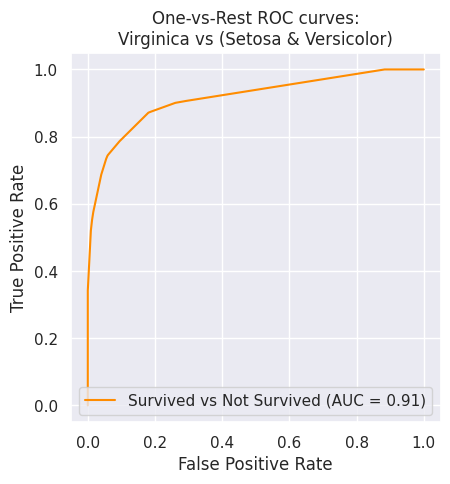


-------- Evaluando <class 'sklearn.ensemble._forest.RandomForestClassifier'> --------
Lo parámetros seleccionados son {'bootstrap': False, 'max_features': 6, 'n_estimators': 12}
La exactitud en el conjunto de entrenamiento, utilizando CV es 0.798
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       561
           1       0.96      0.99      0.98       330

    accuracy                           0.98       891
   macro avg       0.98      0.98      0.98       891
weighted avg       0.98      0.98      0.98       891

[[547  14]
 [  2 328]] 

Sin entrenar: ROC AUC = 0.500
Regresión Logistica: ROC AUC = 0.999


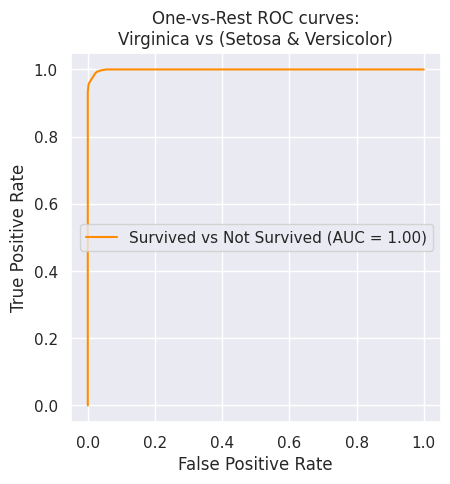


-------- Evaluando <class 'sklearn.neighbors._classification.KNeighborsClassifier'> --------
Lo parámetros seleccionados son {'n_neighbors': 28}
La exactitud en el conjunto de entrenamiento, utilizando CV es 0.806
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       616
           1       0.68      0.84      0.75       275

    accuracy                           0.83       891
   macro avg       0.80      0.83      0.81       891
weighted avg       0.84      0.83      0.83       891

[[505 111]
 [ 44 231]] 

Sin entrenar: ROC AUC = 0.500
Regresión Logistica: ROC AUC = 0.870


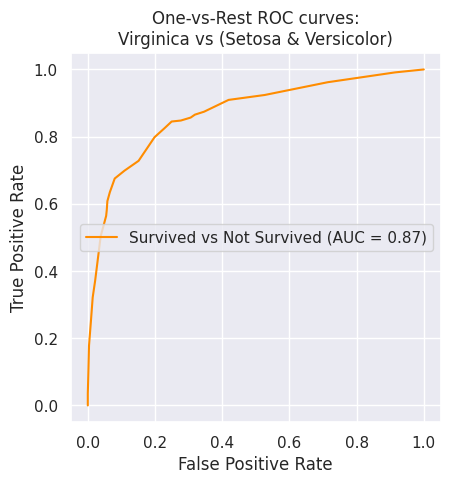


-------- Evaluando <class 'sklearn.svm._classes.SVC'> --------
Lo parámetros seleccionados son {'degree': 1, 'probability': True}
La exactitud en el conjunto de entrenamiento, utilizando CV es 0.822
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       586
           1       0.73      0.81      0.77       305

    accuracy                           0.83       891
   macro avg       0.81      0.83      0.82       891
weighted avg       0.84      0.83      0.83       891

[[492  94]
 [ 57 248]] 

Sin entrenar: ROC AUC = 0.500
Regresión Logistica: ROC AUC = 0.861


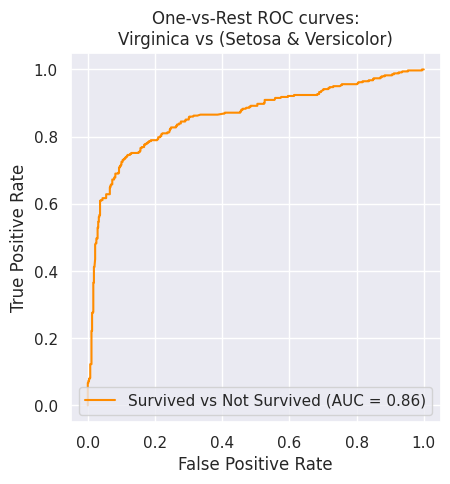


-------- Evaluando <class 'sklearn.linear_model._logistic.LogisticRegression'> --------
Lo parámetros seleccionados son {}
La exactitud en el conjunto de entrenamiento, utilizando CV es 0.790
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       577
           1       0.70      0.76      0.73       314

    accuracy                           0.80       891
   macro avg       0.78      0.79      0.79       891
weighted avg       0.81      0.80      0.80       891

[[475 102]
 [ 74 240]] 

Sin entrenar: ROC AUC = 0.500
Regresión Logistica: ROC AUC = 0.858


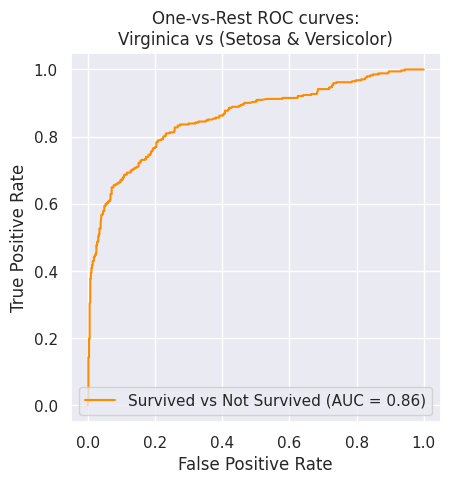

In [46]:
for model, param_grid in zip(models, parameters):
    print('\n-------- Evaluando {} --------'.format(type(model)))
    # It made the parameters exploration for each model.
    model_gs = GridSearchCV(
                # Model to try the parameters, parameters to try.
                model,
                param_grid,
                refit=True,
                verbose=0,
                cv=5,
                scoring='accuracy'
            )

    #X_train, X_test, y_train, y_test = train_test_split(X_train_titanic_df, y_train_titanic_df, test_size = 0.25, random_state = 1)

    # Switch to save the best parameters for each model.
    match model:
      case DecisionTreeClassifier():
        best_tree_class = model_gs
      case RandomForestClassifier():
        best_rf_class = model_gs
      case KNeighborsClassifier():
        best_knn_class = model_gs
      case SVC():
        best_svm_class = model_gs
      case LogisticRegression():
        best_log_reg = model_gs

    # Training each model based on the best one.
    model_gs.fit(X_train_titanic_df, y_train_titanic_df.values.ravel())

    # Making predictions for the model selected.
    y_pred = model_gs.predict(X_train_titanic_df)

    print('Lo parámetros seleccionados son {}'.format(model_gs.best_params_))

    best_model_index = np.argmin(model_gs.cv_results_['rank_test_score'])

    print('La exactitud en el conjunto de entrenamiento, utilizando CV es {:.3f}'.format(
        model_gs.cv_results_['mean_test_score'][best_model_index]
    ))

    print(classification_report(y_pred, y_train_titanic_df))
    print(confusion_matrix(y_pred, y_train_titanic_df), "\n")

    # Plotting the ROC Curve.
    y_proba = model_gs.predict_proba(X_train_titanic_df)[:, 1]
    ns_proba = [0 for _ in range (len(y_train_titanic_df))]

    ns_auc = roc_auc_score(y_train_titanic_df, ns_proba).reshape(-1,1)
    lr_auc = roc_auc_score(y_train_titanic_df, y_proba).reshape(-1,1)

    print("Sin entrenar: ROC AUC = %.3F" % (ns_auc))
    print("Regresión Logistica: ROC AUC = %.3F" % (lr_auc))

    RocCurveDisplay.from_predictions(
      y_train_titanic_df,
      y_proba,
      name=f"Survived vs Not Survived",
      color="darkorange",
    )
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
    plt.legend()
    plt.show()

In [47]:
# Show which parameters were the best for each model.
print('Lo parámetros seleccionados TREES {}'.format(best_tree_class.best_params_))
print('Lo parámetros seleccionados RF {}'.format(best_rf_class.best_params_))
print('Lo parámetros seleccionados KNN {}'.format(best_knn_class.best_params_))
print('Lo parámetros seleccionados SVM {}'.format(best_svm_class.best_params_))
print('Lo parámetros seleccionados LR {}'.format(best_log_reg.best_params_))

Lo parámetros seleccionados TREES {'max_depth': 6}
Lo parámetros seleccionados RF {'bootstrap': False, 'max_features': 6, 'n_estimators': 12}
Lo parámetros seleccionados KNN {'n_neighbors': 28}
Lo parámetros seleccionados SVM {'degree': 1, 'probability': True}
Lo parámetros seleccionados LR {}


## 3) Exploration and Data Pre-processing for Testing Dataset.

#### a) Distributions.
<ul>
 <li> Verify if the data is balanced in the classes in which it should be separate the data.
 </li>
 <li> Analyze the distribution of categorical data and its relationship with the class "survived." Begin to identify characteristics relevant to an accurate classification.
 </li>
 <li> Understand the distribution of numerical data and determine if it is necessary to apply normalization or standardization processes.
 </li>
</ul>

In [48]:
# Reorganizing dataset only for visual purposes.
test_titanic_df = test_titanic_df[["PassengerId", "Name", "Sex", "Age", "Pclass", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]]

In [49]:
# Showing information about the dataset.
test_titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Name         418 non-null    object 
 2   Sex          418 non-null    object 
 3   Age          332 non-null    float64
 4   Pclass       418 non-null    int64  
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [50]:
# Show how distributed "Sex" feature is within the dataset.
test_titanic_df["Sex"].value_counts()

male      266
female    152
Name: Sex, dtype: int64

In [51]:
# Show how distributed "Ticket" feature is within the dataset.
test_titanic_df["Ticket"].value_counts()

PC 17608    5
CA. 2343    4
113503      4
PC 17483    3
220845      3
           ..
349226      1
2621        1
4133        1
113780      1
2668        1
Name: Ticket, Length: 363, dtype: int64

In [52]:
# Show how distributed "Cabin" feature is within the dataset.
test_titanic_df["Cabin"].value_counts()

B57 B59 B63 B66    3
B45                2
C89                2
C55 C57            2
A34                2
                  ..
E52                1
D30                1
E31                1
C62 C64            1
C105               1
Name: Cabin, Length: 76, dtype: int64

In [53]:
# Show how distributed "Embarked" feature is within the dataset.
test_titanic_df["Embarked"].value_counts()

S    270
C    102
Q     46
Name: Embarked, dtype: int64

In [54]:
# Showing statistics about the dataset.
test_titanic_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,418.0,1100.500000,120.810458,892.00,996.2500,1100.5000,1204.75,1309.0000
Age,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.00,76.0000
Pclass,418.0,2.265550,0.841838,1.00,1.0000,3.0000,3.00,3.0000
SibSp,418.0,0.447368,0.896760,0.00,0.0000,0.0000,1.00,8.0000
Parch,418.0,0.392344,0.981429,0.00,0.0000,0.0000,0.00,9.0000
Fare,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.50,512.3292


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

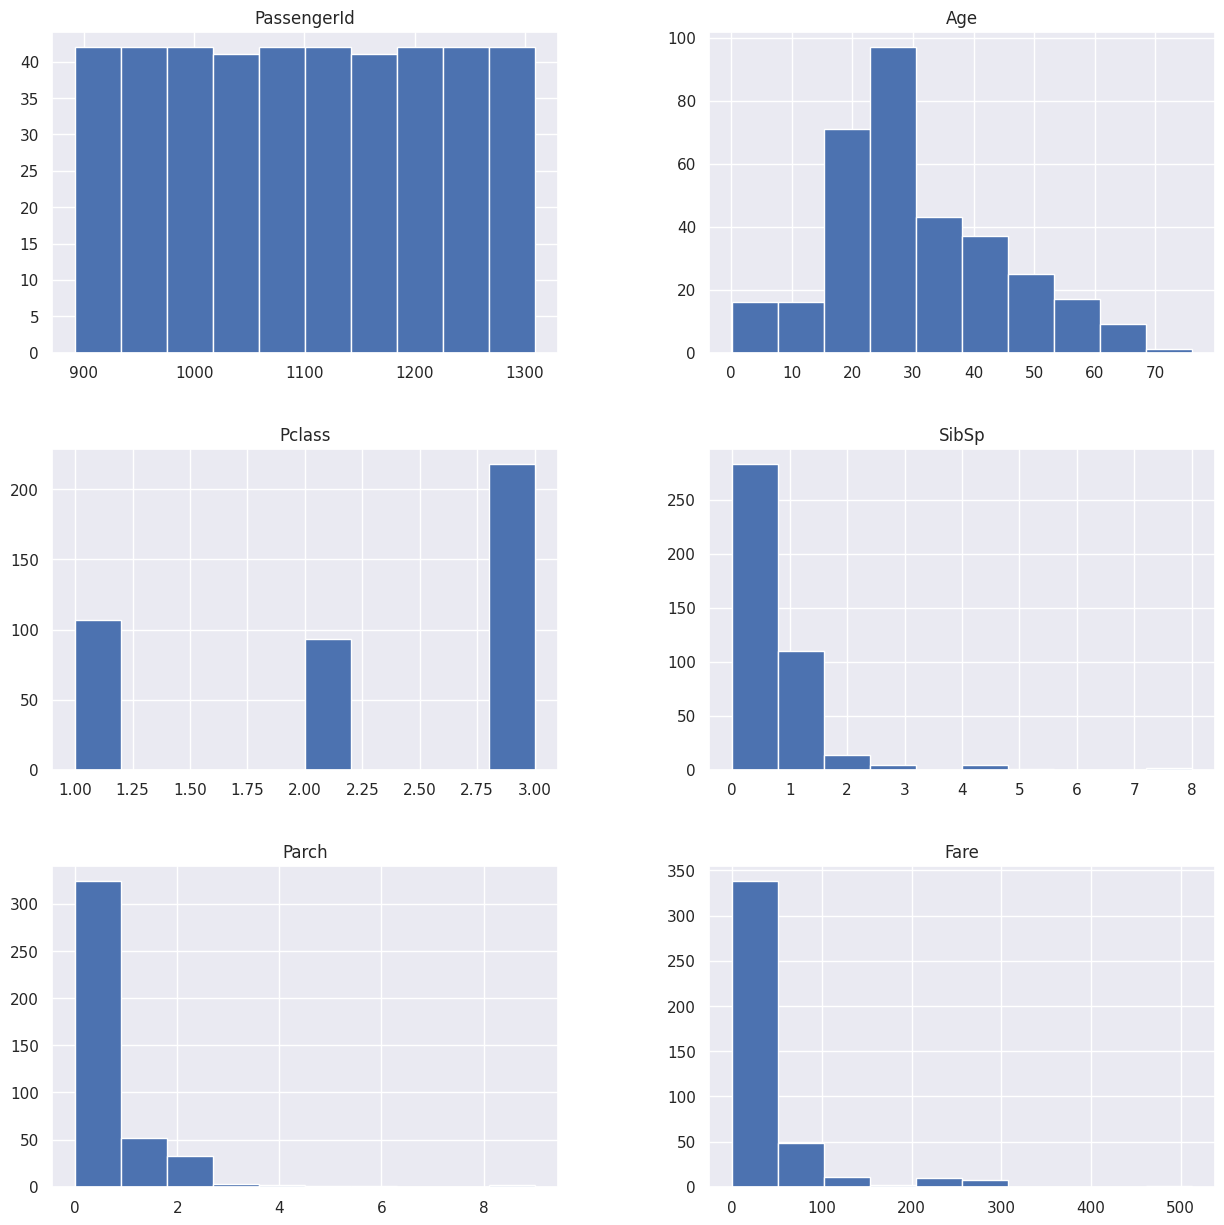

In [55]:
# Showing the distribution throughout the dataset.
test_titanic_df.hist(figsize = (15, 15), bins = 10)

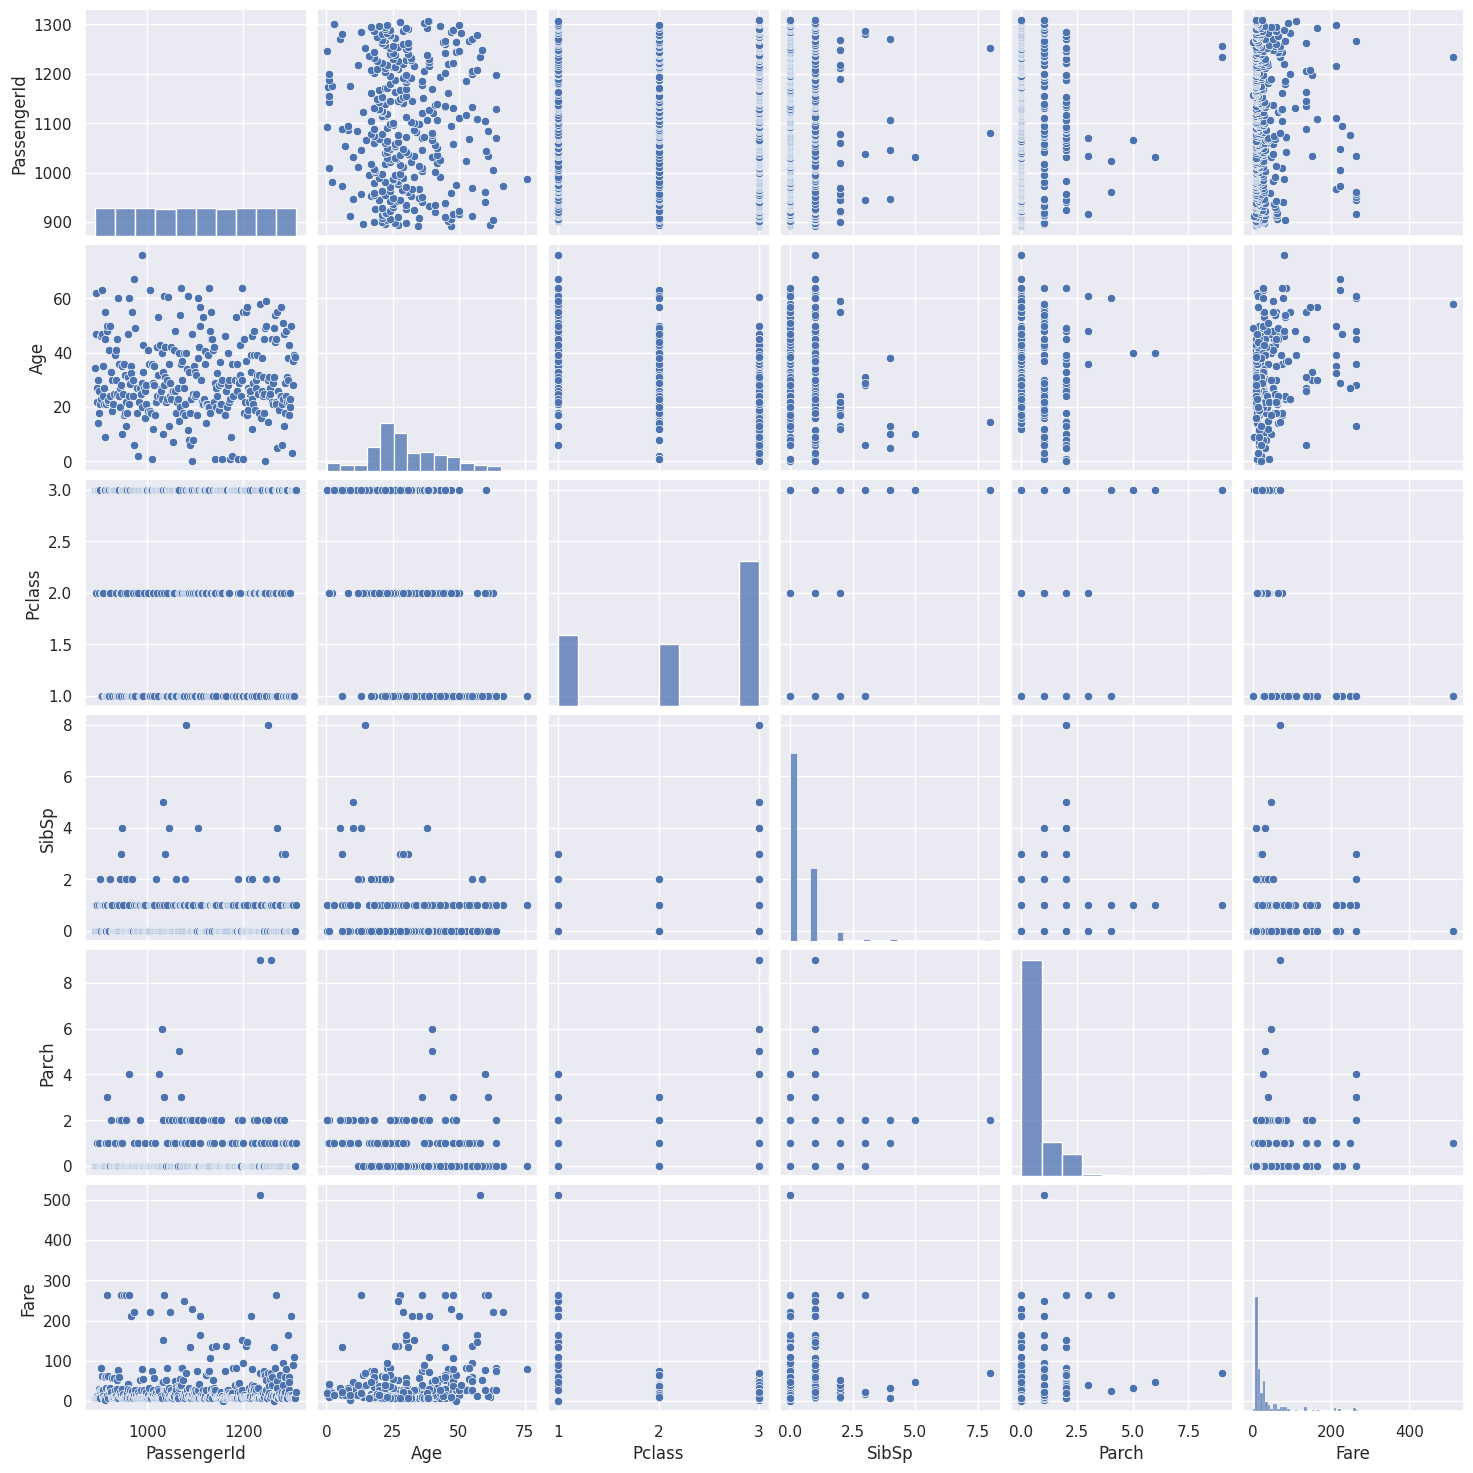

In [56]:
sns.pairplot(test_titanic_df)

#### b) Missing values.
<ul>
 <li> Identify and visualize missing data.
 </li>
 <li> Decide which characteristics require imputations and which do not. Justify the decision and remove unselected columns.
 </li>
 <li> Apply imputation techniques for missing data. Select the best technique and justify the choice.
 </li>
</ul>

In [57]:
# Identify if any feature has missing values.
test_titanic_df.isnull().sum()

PassengerId      0
Name             0
Sex              0
Age             86
Pclass           0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

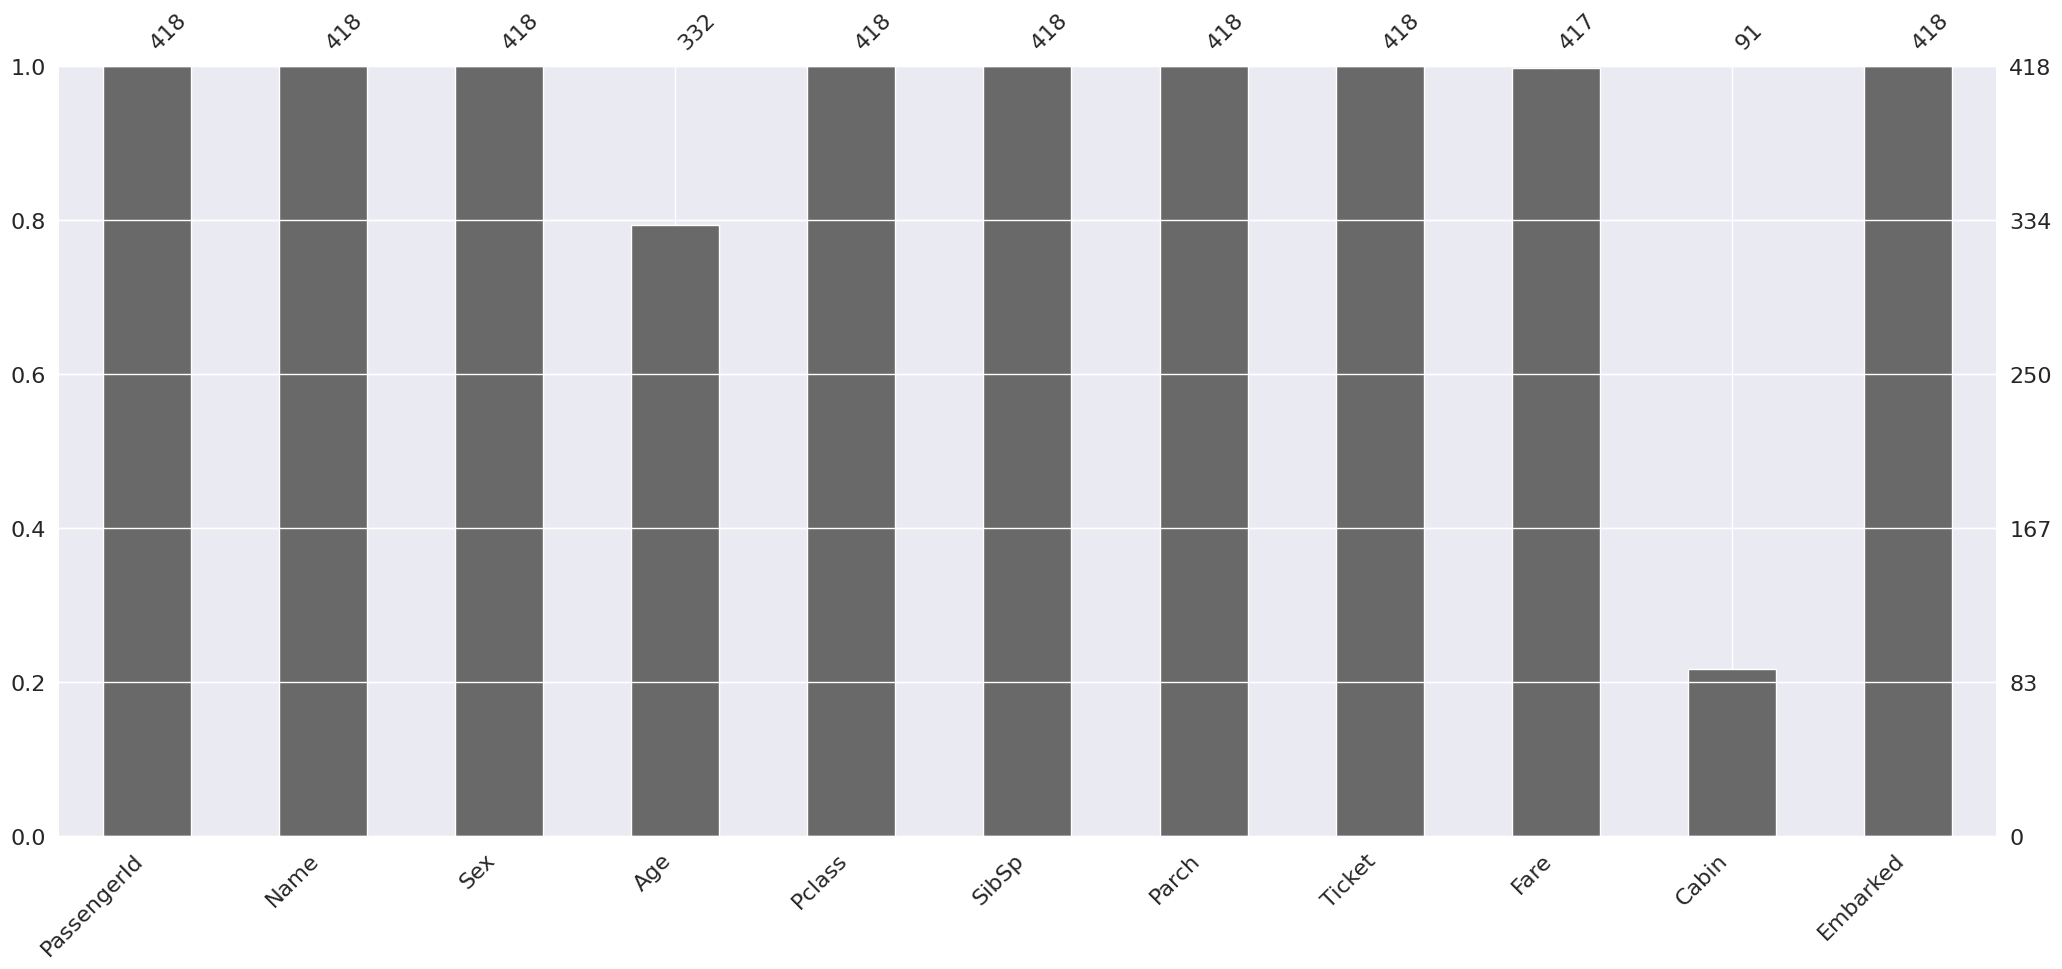

In [58]:
# Verify the missing values of the dataset.
missing_values = msno.bar(test_titanic_df)

In [59]:
# Obtain the thresholds that will say if a value is an outlier.
outlier_test_titanic_df = test_titanic_df[["Pclass","Age","SibSp","Parch","Fare"]]

for i in outlier_test_titanic_df.columns:
    print("Thresholds of {} : ({:.2f}, {:.2f})".format(i, *outlier_thresholds(outlier_test_titanic_df, i)))

Thresholds of Pclass : (-2.00, 6.00)
Thresholds of Age : (-6.00, 66.00)
Thresholds of SibSp : (-1.50, 2.50)
Thresholds of Parch : (0.00, 0.00)
Thresholds of Fare : (-27.51, 66.91)


In [60]:
# Verify number of outliers for numerical features.
outliers_encounters(test_titanic_df, "Pclass")
outliers_encounters(test_titanic_df, "Age")
outliers_encounters(test_titanic_df, "SibSp")
outliers_encounters(test_titanic_df, "Parch")
outliers_encounters(test_titanic_df, "Fare")

Number of outliers for Pclass: 0
Number of outliers for Age: 2
Number of outliers for SibSp: 11
Number of outliers for Parch: 94
Number of outliers for Fare: 55


In [61]:
# Obtain a missing values per feature table.
na_cols = missing_values_table(test_titanic_df, True)

       n_miss  ratio
Cabin     327  78.23
Age        86  20.57
Fare        1   0.24


In [62]:
# Fill the missing values of the features that we are going to keep.
test_titanic_df['Age'].fillna(test_titanic_df['Age'].median(), inplace=True)
test_titanic_df['Fare'].fillna(test_titanic_df['Fare'].mode()[0], inplace=True)

#### d) Data Transformation.
<ul>
 <li> Convert categorical data to numerical data. Explore different methods and select the most suitable one. Justify the choice.
 </li>
</ul>

In [63]:
# Transforming sex categories into numerical here only to appear in plotting charts.
test_titanic_df["isFemale"] = test_titanic_df.apply(isFemale, axis = 1)

# Drop the features that we are not going to use and review the transformation of Sex.
test_titanic_df = test_titanic_df.drop(["PassengerId", "Name", "Sex", "Ticket", "Cabin"], axis = 1)
test_titanic_df["isFemale"].value_counts()

0    266
1    152
Name: isFemale, dtype: int64

In [64]:
# Make a standarization on the features.
scaler = StandardScaler()
features = ['Age', 'SibSp', 'Parch', 'Fare']
test_titanic_df[features] = scaler.fit_transform(test_titanic_df[features])

test_titanic_df = pd.get_dummies(test_titanic_df, columns=['Embarked'], prefix=['Embarked'])

test_titanic_df = test_titanic_df[["Age", "Pclass", "SibSp", "Parch", "Fare", "Embarked_C", "Embarked_Q", "Embarked_S", "isFemale"]]
test_titanic_df.head(2)

,Age,Pclass,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,isFemale
0,0.334993,3,-0.499470,-0.400248,-0.497063,0,1,0,0
1,1.325530,3,0.616992,-0.400248,-0.511926,0,0,1,1


In [65]:
# Showing information about the dataset.
test_titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         418 non-null    float64
 1   Pclass      418 non-null    int64  
 2   SibSp       418 non-null    float64
 3   Parch       418 non-null    float64
 4   Fare        418 non-null    float64
 5   Embarked_C  418 non-null    uint8  
 6   Embarked_Q  418 non-null    uint8  
 7   Embarked_S  418 non-null    uint8  
 8   isFemale    418 non-null    int64  
dtypes: float64(4), int64(2), uint8(3)
memory usage: 20.9 KB


## 4) Predictions for Testing Dataset.


In [66]:
# Reloading the testing dataset and splitting it into features and target class.
X_test_titanic_df = test_titanic_df
y_test_titanic_df = test_true_labels[["Survived"]]

In [67]:
# Evaluate the performance of the Decision Tree Model on the testing dataset.
evaluate_best_models(best_tree_class, X_test_titanic_df, y_test_titanic_df, 1)

Final MSE:  0.11483253588516747
Final RMSE:  0.33886949683494305
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       278
           1       0.80      0.87      0.84       140

    accuracy                           0.89       418
   macro avg       0.87      0.88      0.87       418
weighted avg       0.89      0.89      0.89       418

[[248  30]
 [ 18 122]] 



In [68]:
# Evaluate the performance of the Random Forest Model on the testing dataset.
evaluate_best_models(best_rf_class, X_test_titanic_df, y_test_titanic_df, 2)

Final MSE:  0.22727272727272727
Final RMSE:  0.4767312946227962
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       279
           1       0.64      0.71      0.67       139

    accuracy                           0.77       418
   macro avg       0.75      0.76      0.75       418
weighted avg       0.78      0.77      0.78       418

[[225  54]
 [ 41  98]] 



In [69]:
# Evaluate the performance of the k-Nearest Neighbours Model on the testing dataset.
evaluate_best_models(best_knn_class, X_test_titanic_df, y_test_titanic_df, 3)

Final MSE:  0.17464114832535885
Final RMSE:  0.41790088337470505
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       277
           1       0.72      0.78      0.75       141

    accuracy                           0.83       418
   macro avg       0.80      0.81      0.81       418
weighted avg       0.83      0.83      0.83       418

[[235  42]
 [ 31 110]] 



In [70]:
# Evaluate the performance of the Support Vector Machine Model on the testing dataset.
evaluate_best_models(best_svm_class, X_test_titanic_df, y_test_titanic_df, 4)


Final MSE:  0.050239234449760764
Final RMSE:  0.22414110388271216
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       263
           1       0.94      0.92      0.93       155

    accuracy                           0.95       418
   macro avg       0.95      0.94      0.95       418
weighted avg       0.95      0.95      0.95       418

[[254   9]
 [ 12 143]] 



In [71]:
# Evaluate the performance of the Logistic Regression Model on the testing dataset.
evaluate_best_models(best_log_reg, X_test_titanic_df, y_test_titanic_df, 5)

Final MSE:  0.05741626794258373
Final RMSE:  0.23961691914926153
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       266
           1       0.92      0.92      0.92       152

    accuracy                           0.94       418
   macro avg       0.94      0.94      0.94       418
weighted avg       0.94      0.94      0.94       418

[[254  12]
 [ 12 140]] 

